In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
df = pd.read_csv('data/mobile_game_inapp_purchases.csv')

In [3]:
df.head()

,UserID,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,SpendingSegment,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseDate
0,c9889ab0-9cfc-4a75-acd9-5eab1df0015c,49.0,Male,Norway,Android,Battle Royale,9,12.83,Minnow,11.40,28.0,Apple Pay,2025-03-19
1,7c9e413c-ecca-45f2-a780-2826a07952a2,15.0,Male,Switzerland,iOS,Action RPG,11,19.39,Minnow,6.37,18.0,Debit Card,2025-06-08
2,fd61e419-1a92-4f43-a8c7-135842ad328a,23.0,Male,China,Android,Fighting,9,8.87,Minnow,15.81,30.0,Apple Pay,2025-06-02
3,bdb7f6d1-ff9a-468c-afe7-43f32a94293e,31.0,Male,Mexico,Android,Racing,12,19.56,Minnow,13.49,9.0,Debit Card,2025-04-01
4,aa7eec14-4846-47b9-b879-9c98038cda04,37.0,Female,India,Android,Battle Royale,10,15.23,Minnow,10.86,15.0,Paypal,2025-05-05


In [4]:
df.isna().sum()

UserID                             0
Age                               60
Gender                            60
Country                           60
Device                            60
GameGenre                         60
SessionCount                       0
AverageSessionLength               0
SpendingSegment                    0
InAppPurchaseAmount              136
FirstPurchaseDaysAfterInstall    136
PaymentMethod                    136
LastPurchaseDate                 136
dtype: int64

In [5]:
# Numerical Imputation
df['Age'].fillna(df['Age'].median(), inplace=True)
df['InAppPurchaseAmount'].fillna(df['InAppPurchaseAmount'].median(), inplace=True)
df['FirstPurchaseDaysAfterInstall'].fillna(df['FirstPurchaseDaysAfterInstall'].median(), inplace=True)

# Categorical Imputation
categorical_cols_with_na = ['Gender', 'Country', 'Device', 'GameGenre', 'PaymentMethod', 'LastPurchaseDate']
for col in categorical_cols_with_na:
    df[col].fillna('Unknown', inplace=True)


In [6]:
df.isna().sum()

UserID                           0
Age                              0
Gender                           0
Country                          0
Device                           0
GameGenre                        0
SessionCount                     0
AverageSessionLength             0
SpendingSegment                  0
InAppPurchaseAmount              0
FirstPurchaseDaysAfterInstall    0
PaymentMethod                    0
LastPurchaseDate                 0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UserID                         3024 non-null   object 
 1   Age                            3024 non-null   float64
 2   Gender                         3024 non-null   object 
 3   Country                        3024 non-null   object 
 4   Device                         3024 non-null   object 
 5   GameGenre                      3024 non-null   object 
 6   SessionCount                   3024 non-null   int64  
 7   AverageSessionLength           3024 non-null   float64
 8   SpendingSegment                3024 non-null   object 
 9   InAppPurchaseAmount            3024 non-null   float64
 10  FirstPurchaseDaysAfterInstall  3024 non-null   float64
 11  PaymentMethod                  3024 non-null   object 
 12  LastPurchaseDate               3024 non-null   o

In [8]:
df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'], errors='coerce')
df['Age'] = df['Age'].astype('int64')
df['SessionCount'] = df['SessionCount'].astype('int64')
df['FirstPurchaseDaysAfterInstall'] = df['FirstPurchaseDaysAfterInstall'].astype('int64')

In [9]:
df['LastPurchaseYear'] = df['LastPurchaseDate'].dt.year
df['LastPurchaseMonth'] = df['LastPurchaseDate'].dt.month
df['LastPurchaseDayOfWeek'] = df['LastPurchaseDate'].dt.dayofweek
df['LastPurchaseYear'].fillna(df['LastPurchaseYear'].median(), inplace=True)
df['LastPurchaseMonth'].fillna(df['LastPurchaseMonth'].median(), inplace=True)
df['LastPurchaseDayOfWeek'].fillna(df['LastPurchaseDayOfWeek'].median(), inplace=True)
df['LastPurchaseYear'] = df['LastPurchaseYear'].astype('int64')
df['LastPurchaseMonth'] = df['LastPurchaseMonth'].astype('int64')
df['LastPurchaseDayOfWeek'] = df['LastPurchaseDayOfWeek'].astype('int64')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   UserID                         3024 non-null   object        
 1   Age                            3024 non-null   int64         
 2   Gender                         3024 non-null   object        
 3   Country                        3024 non-null   object        
 4   Device                         3024 non-null   object        
 5   GameGenre                      3024 non-null   object        
 6   SessionCount                   3024 non-null   int64         
 7   AverageSessionLength           3024 non-null   float64       
 8   SpendingSegment                3024 non-null   object        
 9   InAppPurchaseAmount            3024 non-null   float64       
 10  FirstPurchaseDaysAfterInstall  3024 non-null   int64         
 11  PaymentMethod    

In [11]:
df_model = df.drop(columns=['UserID', 'LastPurchaseDate'])

In [12]:
df_model.head()

,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,SpendingSegment,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek
0,49,Male,Norway,Android,Battle Royale,9,12.83,Minnow,11.40,28,Apple Pay,2025,3,2
1,15,Male,Switzerland,iOS,Action RPG,11,19.39,Minnow,6.37,18,Debit Card,2025,6,6
2,23,Male,China,Android,Fighting,9,8.87,Minnow,15.81,30,Apple Pay,2025,6,0
3,31,Male,Mexico,Android,Racing,12,19.56,Minnow,13.49,9,Debit Card,2025,4,1
4,37,Female,India,Android,Battle Royale,10,15.23,Minnow,10.86,15,Paypal,2025,5,0


In [13]:
categorical_features = df_model.select_dtypes(include="object").columns
numerical_features = df_model.select_dtypes(exclude="object").columns

print("Categorical Features identified:", list(categorical_features))
print("Numerical Features identified:", list(numerical_features))

Categorical Features identified: ['Gender', 'Country', 'Device', 'GameGenre', 'SpendingSegment', 'PaymentMethod']
Numerical Features identified: ['Age', 'SessionCount', 'AverageSessionLength', 'InAppPurchaseAmount', 'FirstPurchaseDaysAfterInstall', 'LastPurchaseYear', 'LastPurchaseMonth', 'LastPurchaseDayOfWeek']


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

processed_data = preprocessor.fit_transform(df_model)

print("Shape of processed data:", processed_data.shape)

Shape of processed data: (3024, 70)


### K-Means

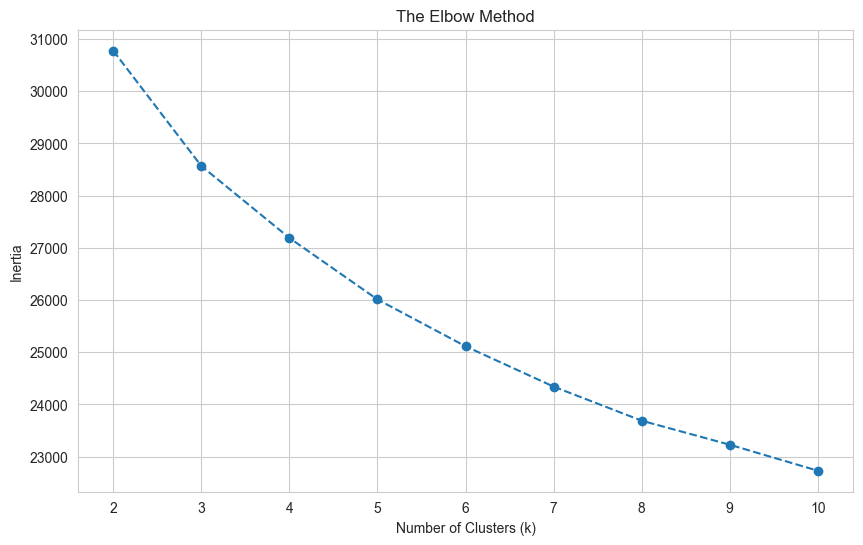

In [15]:
# range of cluster numbers from 2 to 10
k_range = range(2, 11)
inertia_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data)
    inertia_scores.append(kmeans.inertia_)

# Plot the results to find the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Silhouette Score for k = 2: 0.4813
Silhouette Score for k = 3: 0.0753
Silhouette Score for k = 4: 0.0655
Silhouette Score for k = 5: 0.0686
Silhouette Score for k = 6: 0.0685
Silhouette Score for k = 7: 0.0697
Silhouette Score for k = 8: 0.0690
Silhouette Score for k = 9: 0.0664
Silhouette Score for k = 10: 0.0677


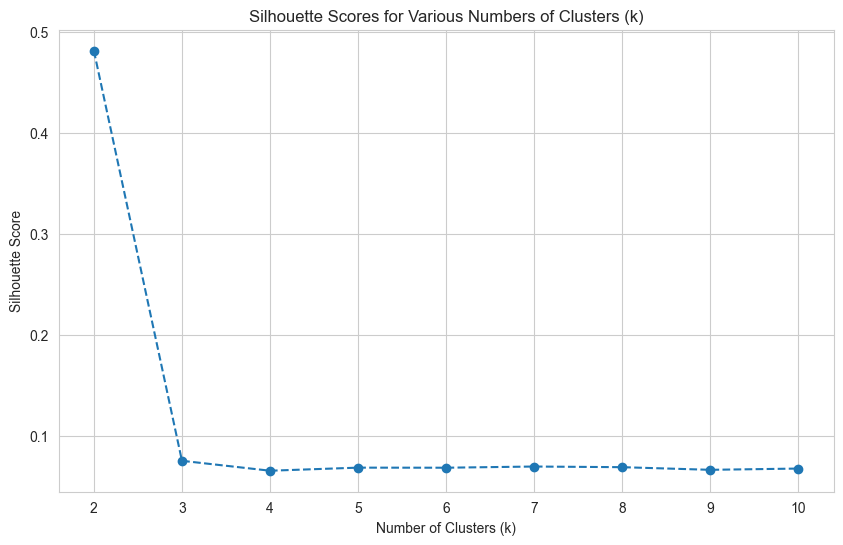

In [16]:
# We will test a range of cluster numbers from 2 to 10
k_range = range(2, 11)
silhouette_scores = []

# Loop through each possible number of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data)
    score = silhouette_score(processed_data, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k = {k}: {score:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Various Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [17]:
optimal_k = 2

# K-Means model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_data)

df['Cluster'] = cluster_labels

print(f"K-Means model with {optimal_k} clusters has been trained successfully.")
df['Cluster'].value_counts()

K-Means model with 2 clusters has been trained successfully.


Cluster
1    2973
0      51
Name: count, dtype: int64

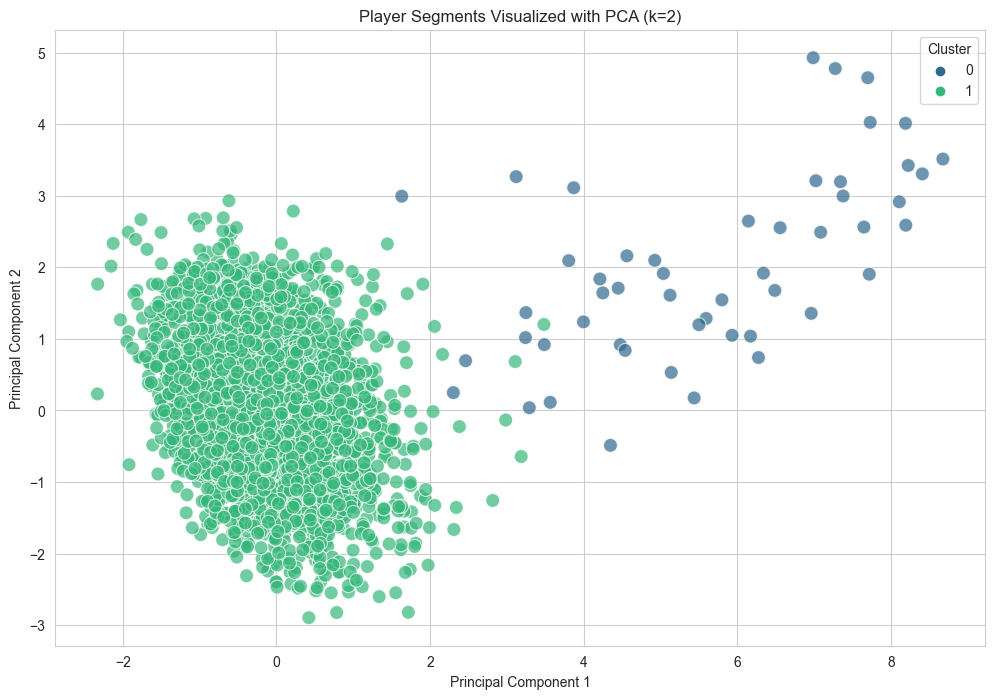

In [18]:
# Initialize PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(processed_data.toarray() if hasattr(processed_data, "toarray") else processed_data)

# Create a new DataFrame for plotting
df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('Player Segments Visualized with PCA (k=2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [19]:
# Group the original dataframe by the new 'Cluster' column and calculate the mean for all numerical features
cluster_profile = df.groupby('Cluster').mean(numeric_only=True)

print("Cluster Profiles (averages for numerical features):")
print(cluster_profile)

Cluster Profiles (averages for numerical features):
               Age  SessionCount  AverageSessionLength  InAppPurchaseAmount  \
Cluster                                                                       
0        34.764706     10.941176             18.992157          3211.787843   
1        33.501850     10.059872             20.092536            45.101490   

         FirstPurchaseDaysAfterInstall  LastPurchaseYear  LastPurchaseMonth  \
Cluster                                                                       
0                            16.705882            2025.0           4.215686   
1                            15.389506            2025.0           4.293979   

         LastPurchaseDayOfWeek  
Cluster                         
0                     2.901961  
1                     3.017154  


#### Not happy with current result will try something new now creating new dataset without InAppPurchaseAmount as it is creating problem

In [20]:
df_model_behavior = df.drop(columns=['UserID', 'LastPurchaseDate', 'SpendingSegment', 'InAppPurchaseAmount'])

categorical_features = df_model_behavior.select_dtypes(include="object").columns
numerical_features = df_model_behavior.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

processed_data_behavior = preprocessor.fit_transform(df_model_behavior)

print("--- Behavior-only data has been pre-processed successfully ---")
print("This is the data we will use for our next steps.")
print("Shape of the new processed data:", processed_data_behavior.shape)

--- Behavior-only data has been pre-processed successfully ---
This is the data we will use for our next steps.
Shape of the new processed data: (3024, 67)


Behavior-Only Silhouette Score for k = 2: 0.5113
Behavior-Only Silhouette Score for k = 3: 0.0804
Behavior-Only Silhouette Score for k = 4: 0.0701
Behavior-Only Silhouette Score for k = 5: 0.0738
Behavior-Only Silhouette Score for k = 6: 0.0729
Behavior-Only Silhouette Score for k = 7: 0.0745
Behavior-Only Silhouette Score for k = 8: 0.0746
Behavior-Only Silhouette Score for k = 9: 0.0728
Behavior-Only Silhouette Score for k = 10: 0.0724


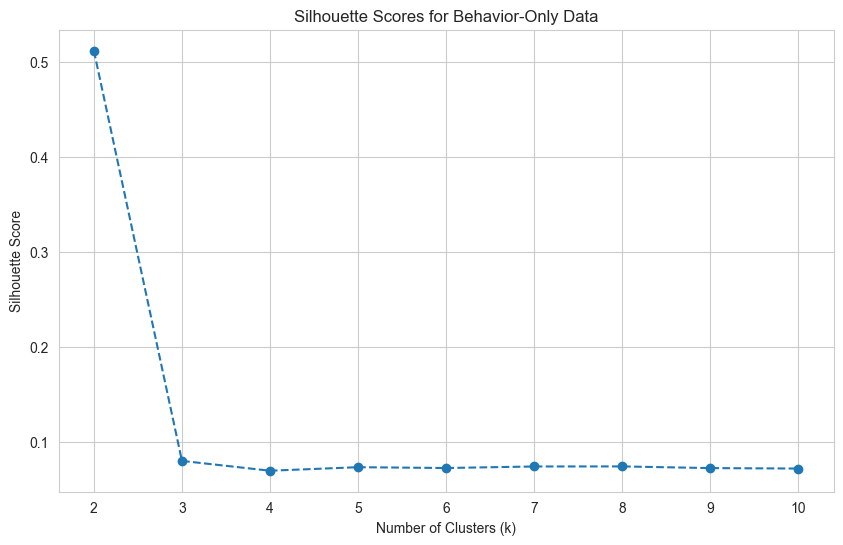

In [21]:
k_range2 = range(2, 11)
silhouette_scores2 = []

for k in k_range2:
    kmeans2 = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans2.fit(processed_data_behavior)
    score2 = silhouette_score(processed_data_behavior, kmeans2.labels_)
    silhouette_scores2.append(score2)
    print(f"Behavior-Only Silhouette Score for k = {k}: {score2:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range2, silhouette_scores2, marker='o', linestyle='--')
plt.title('Silhouette Scores for Behavior-Only Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range2)
plt.grid(True)
plt.show()

In [22]:
# Set the optimal number of clusters based on the highest Silhouette Score
optimal_k = 2

# Initialize and train the final K-Means model on the behavior data
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_data_behavior)

# Add these new 'BehaviorCluster' labels back to our main 'df' to analyze them
df['BehaviorCluster'] = cluster_labels

print(f"Behavioral K-Means model with {optimal_k} clusters has been trained.")
df['BehaviorCluster'].value_counts()


Behavioral K-Means model with 2 clusters has been trained.


BehaviorCluster
1    2973
0      51
Name: count, dtype: int64

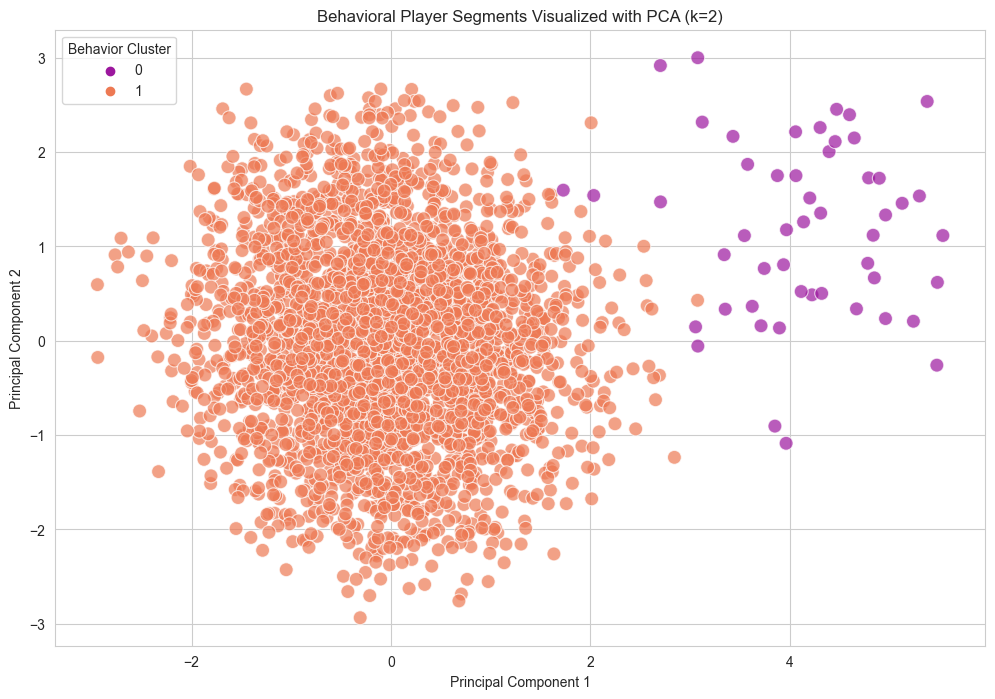

In [23]:
# We can reuse the PCA logic on the new processed_data to visualize these clusters
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(processed_data_behavior.toarray())

# Create a new DataFrame for plotting
df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
df_pca['BehaviorCluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='BehaviorCluster', data=df_pca, palette='plasma', s=100, alpha=0.7)
plt.title('Behavioral Player Segments Visualized with PCA (k=2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Behavior Cluster')
plt.grid(True)
plt.show()

In [24]:
# Group by the new 'BehaviorCluster' and calculate the mean for all numerical features
behavioral_profile = df.groupby('BehaviorCluster').mean(numeric_only=True)

print("Behavioral Cluster Profiles (Averages):")
behavioral_profile

Behavioral Cluster Profiles (Averages):


,Age,SessionCount,AverageSessionLength,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek,Cluster
BehaviorCluster,,,,,,,,,
0,34.764706,10.941176,18.992157,3211.787843,16.705882,2025.0,4.215686,2.901961,0.0
1,33.501850,10.059872,20.092536,45.101490,15.389506,2025.0,4.293979,3.017154,1.0
